In [1]:
#import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score,train_test_split
from sklearn import preprocessing
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
from sklearn.ensemble import RandomForestRegressor
from pandas.plotting import autocorrelation_plot
from sklearn.model_selection import TimeSeriesSplit
import talib as ta
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15, 6

In [2]:
'''We have data of 12 diffenret stocks,but we will pick only one for exploration'''
infy_dataset = pd.read_csv("complete_data_set_v1/INFY.NS.csv")

In [3]:
def data_preprocessing(dataset):
    dataset['Date'] = pd.to_datetime(dataset['Date'],format='%Y-%m')
    dataset['Adj Close'] = pd.to_numeric(dataset['Adj Close'],errors='coerce')
    dataset['Volume'] = pd.to_numeric(dataset['Volume'],errors='coerce')
    dataset['Close'] = pd.to_numeric(dataset['Close'],errors='coerce')
    dataset['Low'] = pd.to_numeric(dataset['Low'],errors='coerce')
    dataset['High'] = pd.to_numeric(dataset['High'],errors='coerce')
    dataset['Open'] = pd.to_numeric(dataset['Open'],errors='coerce')
    
    '''remove rows with any null value'''
    dataset = dataset.dropna(axis=0,how='any')
    
    '''Create new column to show closing price after 30th day'''
    forecast_out = int(30) # predicting 30 days into future
    dataset['PriceNextMonth'] = dataset[['Adj Close']].shift(-forecast_out)
    '''For last 30 rows,PriceNextMonth will be empty,so remove those rows'''
    dataset = dataset[:-forecast_out]# remove last 30 from X
    
    return dataset
    

In [4]:
def evaluate_model(model,X_train, X_test, y_train, y_test):
    confidence = model.score(X_test, y_test)
    print("score: ", confidence)
    
    scores = cross_val_score(model, X_train, y_train, cv=5)
    print("cross_val_score: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))
    
    y_pred = model.predict(X_test)
    mae = mean_absolute_error(y_test, y_pred)
    print("mean_absolute_error: ", mae)
    #plt.plot(y_test)
    #plt.plot(y_pred, color='red')
    #plt.show()

In [5]:
def evaluate_random_forest(dataset,features,response):
    tscv = TimeSeriesSplit(n_splits=12)
    X = dataset[features].values
    y = np.array(dataset[response])
    index = 1
    total_mae = 0
    for train_index, test_index in tscv.split(dataset.values):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        model = RandomForestRegressor(random_state=0)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        mae = mean_absolute_error(y_test, y_pred)
        print('Fold No: %d'% index)
        print("mean_absolute_error: ", mae)
        feature_importances = pd.DataFrame(model.feature_importances_,index = features,
                                    columns=['importance']).sort_values('importance',ascending=False)
        print(feature_importances)
        total_mae = total_mae+mae
        index += 1
    print("average MAE:",total_mae/index)
    #feature_importances = pd.DataFrame(model.feature_importances_,index = features,
    #                                columns=['importance']).sort_values('importance',ascending=False)
    #print(feature_importances)

In [6]:
processed_dataset = data_preprocessing(infy_dataset)
explore_dataset = processed_dataset.copy()

C:\Users\Vani\Anaconda3\lib\site-packages\ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


In [7]:
'''No feature Engineering'''
features = ["Adj Close"]
response = "PriceNextMonth"
explore_dataset_no_enginr = processed_dataset[["Adj Close","PriceNextMonth"]] 
#X_train, X_test, y_train, y_test = split_dataset(explore_dataset_no_enginr,features,response)
evaluate_random_forest(explore_dataset_no_enginr,features,response)

Fold No: 1
mean_absolute_error:  105.774999167
           importance
Adj Close         1.0
Fold No: 2
mean_absolute_error:  49.9735085391
           importance
Adj Close         1.0
Fold No: 3
mean_absolute_error:  119.013058551
           importance
Adj Close         1.0
Fold No: 4
mean_absolute_error:  55.1754033815
           importance
Adj Close         1.0
Fold No: 5
mean_absolute_error:  79.7010936315
           importance
Adj Close         1.0
Fold No: 6
mean_absolute_error:  71.8316414837
           importance
Adj Close         1.0
Fold No: 7
mean_absolute_error:  89.3672751891
           importance
Adj Close         1.0
Fold No: 8
mean_absolute_error:  66.1696040236
           importance
Adj Close         1.0
Fold No: 9
mean_absolute_error:  49.7948787656
           importance
Adj Close         1.0
Fold No: 10
mean_absolute_error:  51.3712148196
           importance
Adj Close         1.0
Fold No: 11
mean_absolute_error:  47.5013860871
           importance
Adj Close         1

In [8]:
explore_dataset["HL_Perc"] = (processed_dataset["High"]-processed_dataset["Low"]) / processed_dataset["Low"] * 100
explore_dataset["CO_Perc"] = (processed_dataset["Close"] - processed_dataset["Open"]) / processed_dataset["Open"] * 100

#so our dataset now conatins two new columnn and they are change from low to high 
#percentage and closed and open percentage
#we keep only those columns in our datasheet whih we need and remove the rest
explore_dataset = explore_dataset[["HL_Perc", "CO_Perc", "Adj Close","PriceNextMonth"]] 

In [9]:
features = ["HL_Perc", "CO_Perc", "Adj Close"]
response = "PriceNextMonth"
evaluate_random_forest(explore_dataset,features,response)

Fold No: 1
mean_absolute_error:  107.478880401
           importance
Adj Close    0.869263
CO_Perc      0.070276
HL_Perc      0.060461
Fold No: 2
mean_absolute_error:  48.2853677609
           importance
Adj Close    0.941410
CO_Perc      0.032427
HL_Perc      0.026163
Fold No: 3
mean_absolute_error:  107.649259422
           importance
Adj Close    0.882564
CO_Perc      0.063056
HL_Perc      0.054380
Fold No: 4
mean_absolute_error:  68.264976313
           importance
Adj Close    0.912660
HL_Perc      0.043857
CO_Perc      0.043484
Fold No: 5
mean_absolute_error:  69.5167966174
           importance
Adj Close    0.948560
HL_Perc      0.025807
CO_Perc      0.025633
Fold No: 6
mean_absolute_error:  75.9882586043
           importance
Adj Close    0.947511
HL_Perc      0.028738
CO_Perc      0.023751
Fold No: 7
mean_absolute_error:  90.0923903511
           importance
Adj Close    0.955496
HL_Perc      0.023338
CO_Perc      0.021166
Fold No: 8
mean_absolute_error:  62.6794719946
         

In [10]:
'''Here MAE after feature engineering is 64.5992340999 which is less from our base model MAE which is 66.6375400194,
so we are going in correct direction.
Need to find more features to reduce MAE,we will use TA lib for that'''

'Here MAE after feature engineering is 64.5992340999 which is less from our base model MAE which is 66.6375400194,\nso we are going in correct direction.\nNeed to find more features to reduce MAE,we will use TA lib for that'

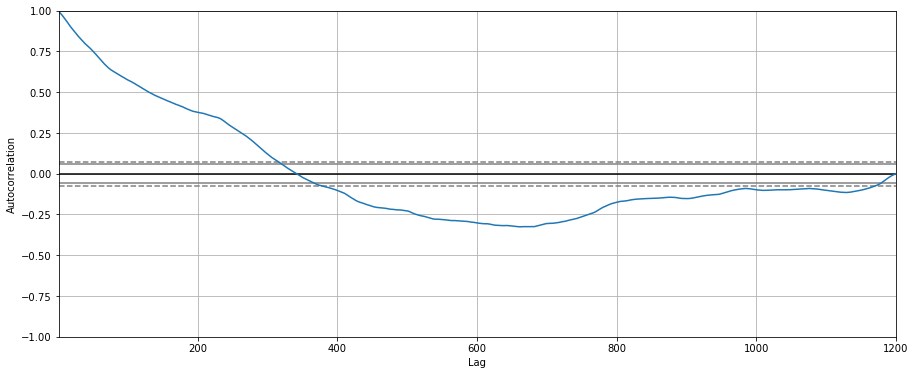

In [11]:
autocorrelation_plot(processed_dataset['Adj Close'])
plt.show()

In [12]:
'''From graph it is clear that Adj Close price is autocorrelated and correlation decreases after 75-100 days
So we will do TA between 0-100 days,not more than that'''

'From graph it is clear that Adj Close price is autocorrelated and correlation decreases after 75-100 days\nSo we will do TA between 0-100 days,not more than that'

In [13]:
'''Let us create numpy array for TA '''
high = processed_dataset['High'].values
low = processed_dataset['Low'].values
close = processed_dataset['Close'].values
open = processed_dataset['Open'].values
volume = processed_dataset['Volume'].values

In [14]:
#1 Simple Moving Average (30,40,50 Days)
SMA = ta.SMA(close, 30)
SMA_dataset = processed_dataset.copy()
SMA_dataset["SMA"] = SMA
SMA_dataset = SMA_dataset[["Adj Close","SMA","PriceNextMonth"]] 
SMA_dataset = SMA_dataset.dropna(axis=0,how='any')
features = ["Adj Close","SMA"]
response = "PriceNextMonth"
evaluate_random_forest(SMA_dataset,features,response)
'''
MAE for SMA 30=68.1949023014
MAE for SMA 40=72.0747132953
MAE for SMA 50=74.4814882069
Hence,SMA 30 can be considered for feature addition
'''

Fold No: 1
mean_absolute_error:  42.8815595489
           importance
Adj Close    0.516631
SMA          0.483369
Fold No: 2
mean_absolute_error:  39.2998084422
           importance
SMA          0.880307
Adj Close    0.119693
Fold No: 3
mean_absolute_error:  136.589304919
           importance
SMA           0.81482
Adj Close     0.18518
Fold No: 4
mean_absolute_error:  81.0824324844
           importance
Adj Close    0.681006
SMA          0.318994
Fold No: 5
mean_absolute_error:  59.1252357611
           importance
Adj Close     0.79281
SMA           0.20719
Fold No: 6
mean_absolute_error:  83.5891388911
           importance
Adj Close    0.829941
SMA          0.170059
Fold No: 7
mean_absolute_error:  106.245968984
           importance
Adj Close    0.862632
SMA          0.137368
Fold No: 8
mean_absolute_error:  95.9868956444
           importance
Adj Close     0.88855
SMA           0.11145
Fold No: 9
mean_absolute_error:  44.9761694733
           importance
Adj Close    0.894574
SMA  

'\nMAE for SMA 30=68.1949023014\nMAE for SMA 40=72.0747132953\nMAE for SMA 50=74.4814882069\nHence,SMA 30 can be considered for feature addition\n'

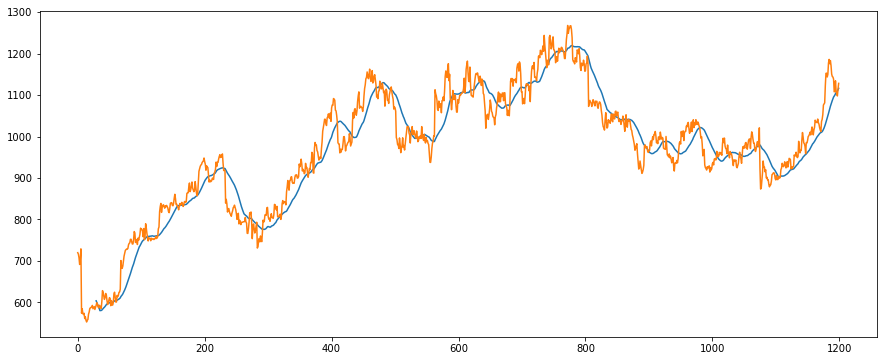

In [15]:
plt.plot(SMA)
plt.plot(close)

In [16]:
#2 Exponential Moving Average (30,40,50 days)
EMA = ta.EMA(close, 30)
EMA_dataset = processed_dataset.copy()
EMA_dataset["EMA"] = EMA
EMA_dataset = EMA_dataset[["Adj Close","EMA","PriceNextMonth"]] 
EMA_dataset = EMA_dataset.dropna(axis=0,how='any')
features = ["Adj Close","EMA"]
response = "PriceNextMonth"
evaluate_random_forest(EMA_dataset,features,response)
'''
MAE for EMA 30=69.722432579
MAE for EMA 40=71.8504120853
MAE for EMA 50=73.4975742016
Hence,EMA 30 can be considered for feature addition
'''

Fold No: 1
mean_absolute_error:  44.1363116378
           importance
EMA          0.569022
Adj Close    0.430978
Fold No: 2
mean_absolute_error:  48.2479000044
           importance
EMA          0.888049
Adj Close    0.111951
Fold No: 3
mean_absolute_error:  132.087242514
           importance
EMA          0.818241
Adj Close    0.181759
Fold No: 4
mean_absolute_error:  81.0824324844
           importance
Adj Close    0.674885
EMA          0.325115
Fold No: 5
mean_absolute_error:  70.8997021322
           importance
Adj Close    0.793919
EMA          0.206081
Fold No: 6
mean_absolute_error:  72.1304566244
           importance
Adj Close    0.828249
EMA          0.171751
Fold No: 7
mean_absolute_error:  104.11606822
           importance
Adj Close    0.860888
EMA          0.139112
Fold No: 8
mean_absolute_error:  98.1389021833
           importance
Adj Close    0.889772
EMA          0.110228
Fold No: 9
mean_absolute_error:  50.4457159467
           importance
Adj Close    0.897139
EMA   

'\nMAE for EMA 30=69.722432579\nMAE for EMA 40=71.8504120853\nMAE for EMA 50=73.4975742016\nHence,EMA 30 can be considered for feature addition\n'

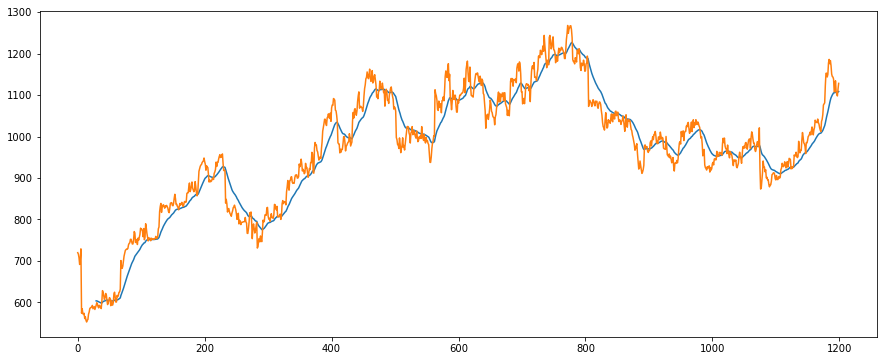

In [17]:
plt.plot(EMA)
plt.plot(close)

In [18]:
#3 Aroon Oscillator (30,40,50 Days)
AROONOSC = ta.AROONOSC(high, low, timeperiod=30)
AROONOSC_dataset = processed_dataset.copy()
AROONOSC_dataset["AROONOSC"] = AROONOSC
AROONOSC_dataset = AROONOSC_dataset[["Adj Close","AROONOSC","PriceNextMonth"]] 
AROONOSC_dataset = AROONOSC_dataset.dropna(axis=0,how='any')
features = ["Adj Close","AROONOSC"]
response = "PriceNextMonth"
evaluate_random_forest(AROONOSC_dataset,features,response)
'''
MAE for AROONOSC 30=68.2690515159
MAE for AROONOSC 40=74.4092875626
MAE for AROONOSC 50=77.348689388
Hence,AROONOSC 30 can be considered for feature addition
'''

Fold No: 1
mean_absolute_error:  53.9467488667
           importance
Adj Close    0.918633
AROONOSC     0.081367
Fold No: 2
mean_absolute_error:  44.8062363389
           importance
Adj Close    0.925712
AROONOSC     0.074288
Fold No: 3
mean_absolute_error:  136.745136258
           importance
Adj Close    0.827484
AROONOSC     0.172516
Fold No: 4
mean_absolute_error:  75.9009604767
           importance
Adj Close    0.911952
AROONOSC     0.088048
Fold No: 5
mean_absolute_error:  100.614139666
           importance
Adj Close    0.945041
AROONOSC     0.054959
Fold No: 6
mean_absolute_error:  68.7593050811
           importance
Adj Close    0.945292
AROONOSC     0.054708
Fold No: 7
mean_absolute_error:  100.732215201
           importance
Adj Close    0.946872
AROONOSC     0.053128
Fold No: 8
mean_absolute_error:  56.975702354
           importance
Adj Close     0.95235
AROONOSC      0.04765
Fold No: 9
mean_absolute_error:  68.8121426978
           importance
Adj Close    0.948885
AROONO

'\nMAE for AROONOSC 30=68.2690515159\nMAE for AROONOSC 40=74.4092875626\nMAE for AROONOSC 50=77.348689388\nHence,AROONOSC 30 can be considered for feature addition\n'

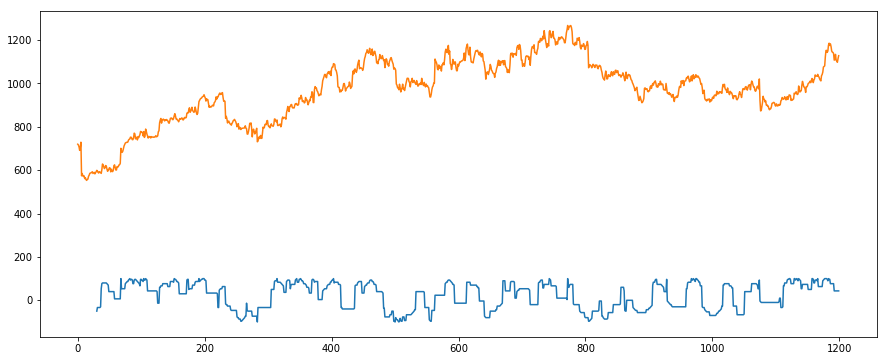

In [19]:
plt.plot(AROONOSC)
plt.plot(close)

In [20]:
#4 MACD - Moving Average Convergence/Divergence
macd, macdsignal, macdhist = ta.MACD(close, fastperiod=12, slowperiod=26, signalperiod=9)
MACD_dataset = processed_dataset.copy()
MACD_dataset["macd"] = macd
MACD_dataset = MACD_dataset[["Adj Close","macd","PriceNextMonth"]] 
MACD_dataset = MACD_dataset.dropna(axis=0,how='any')
features = ["Adj Close","macd"]
response = "PriceNextMonth"
evaluate_random_forest(MACD_dataset,features,response)

Fold No: 1
mean_absolute_error:  55.7855711528
           importance
Adj Close    0.574001
macd         0.425999
Fold No: 2
mean_absolute_error:  36.0525166978
           importance
Adj Close    0.824125
macd         0.175875
Fold No: 3
mean_absolute_error:  156.744220263
           importance
Adj Close      0.7514
macd           0.2486
Fold No: 4
mean_absolute_error:  83.5265780562
           importance
Adj Close    0.882444
macd         0.117556
Fold No: 5
mean_absolute_error:  47.1767003292
           importance
Adj Close     0.92213
macd          0.07787
Fold No: 6
mean_absolute_error:  84.6376513225
           importance
Adj Close    0.935798
macd         0.064202
Fold No: 7
mean_absolute_error:  108.808897172
           importance
Adj Close    0.937669
macd         0.062331
Fold No: 8
mean_absolute_error:  73.5463115899
           importance
Adj Close    0.947945
macd         0.052055
Fold No: 9
mean_absolute_error:  53.6191284034
           importance
Adj Close    0.940345
macd 

In [21]:
#5 Relative Strength Index (RSI)
RSI = ta.RSI(close, timeperiod=14)
RSI_dataset = processed_dataset.copy()
RSI_dataset["RSI"] = RSI
RSI_dataset = RSI_dataset[["Adj Close","RSI","PriceNextMonth"]] 
RSI_dataset = RSI_dataset.dropna(axis=0,how='any')
features = ["Adj Close","RSI"]
response = "PriceNextMonth"
evaluate_random_forest(RSI_dataset,features,response)

Fold No: 1
mean_absolute_error:  56.5795485286
           importance
RSI          0.540571
Adj Close    0.459429
Fold No: 2
mean_absolute_error:  59.5181241385
           importance
Adj Close    0.859812
RSI          0.140188
Fold No: 3
mean_absolute_error:  136.703021432
           importance
Adj Close    0.794976
RSI          0.205024
Fold No: 4
mean_absolute_error:  43.8049042458
           importance
Adj Close    0.899379
RSI          0.100621
Fold No: 5
mean_absolute_error:  65.3006523451
           importance
Adj Close    0.934803
RSI          0.065197
Fold No: 6
mean_absolute_error:  104.985981841
           importance
Adj Close    0.939363
RSI          0.060637
Fold No: 7
mean_absolute_error:  92.3754926033
           importance
Adj Close    0.946865
RSI          0.053135
Fold No: 8
mean_absolute_error:  80.4738604451
           importance
Adj Close    0.954181
RSI          0.045819
Fold No: 9
mean_absolute_error:  65.5643314978
           importance
Adj Close    0.950933
RSI  

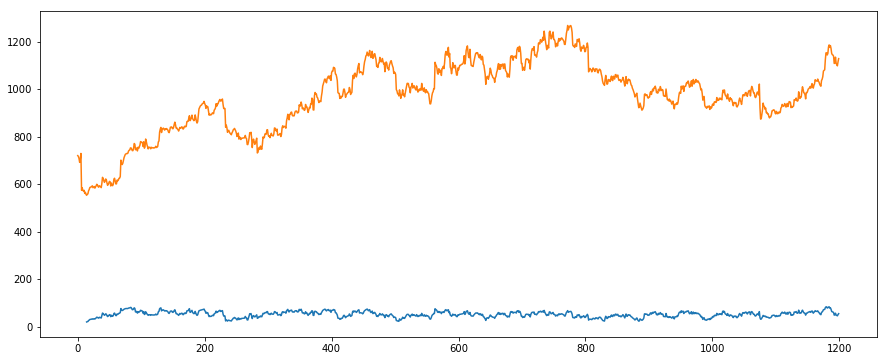

In [22]:
plt.plot(RSI)
plt.plot(close)

In [23]:
#6 Bollinger Bands ( 30, 40, 50 Days)
upperband, middleband, lowerband = ta.BBANDS(close, timeperiod=30, nbdevup=2, nbdevdn=2, matype=0)
BBANDS_dataset = processed_dataset.copy()
BBANDS_dataset["upperband"] = upperband
BBANDS_dataset["middleband"] = middleband
BBANDS_dataset["lowerband"] = lowerband
BBANDS_dataset = BBANDS_dataset[["Adj Close","upperband","middleband","lowerband","PriceNextMonth"]] 
BBANDS_dataset = BBANDS_dataset.dropna(axis=0,how='any')
features = ["Adj Close","upperband","middleband","lowerband"]
response = "PriceNextMonth"
evaluate_random_forest(BBANDS_dataset,features,response)
'''
MAE for BBANDS 30=69.2850691405
MAE for BBANDS 40=70.4524357974
MAE for BBANDS 50=77.3168054141
Hence,BBANDS 30 can be considered for feature addition
'''


Fold No: 1
mean_absolute_error:  45.7995432789
            importance
Adj Close     0.512404
lowerband     0.281208
middleband    0.190594
upperband     0.015793
Fold No: 2
mean_absolute_error:  35.2738112789
            importance
lowerband     0.545762
middleband    0.324990
Adj Close     0.114715
upperband     0.014533
Fold No: 3
mean_absolute_error:  139.208319283
            importance
lowerband     0.492162
middleband    0.240603
Adj Close     0.144265
upperband     0.122970
Fold No: 4
mean_absolute_error:  87.0589008033
            importance
Adj Close     0.669681
middleband    0.179697
lowerband     0.078700
upperband     0.071922
Fold No: 5
mean_absolute_error:  48.1729326989
            importance
Adj Close     0.787699
middleband    0.097424
lowerband     0.078038
upperband     0.036840
Fold No: 6
mean_absolute_error:  89.9498635744
            importance
Adj Close     0.816638
lowerband     0.076617
middleband    0.070695
upperband     0.036050
Fold No: 7
mean_absolute_err

'\nMAE for BBANDS 30=69.2850691405\nMAE for BBANDS 40=70.4524357974\nMAE for BBANDS 50=77.3168054141\nHence,BBANDS 30 can be considered for feature addition\n'

'too erratic to use for feature engineering'

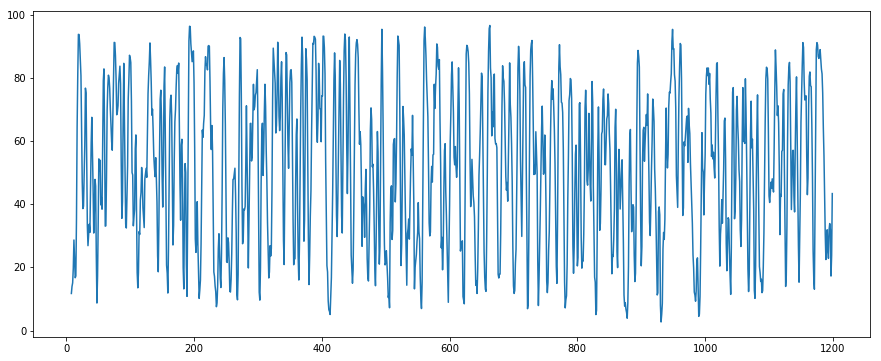

In [24]:
#7 Stochastic Oscillator
slowk, slowd = ta.STOCH(high, low, close, fastk_period=5, slowk_period=3, slowk_matype=0, slowd_period=3, slowd_matype=0)
plt.plot(slowk)
#plt.plot(slowd)
'''too erratic to use for feature engineering'''

In [25]:
#8 Stochastic momentum Indicator
'''TA lib does not have support for this'''


'TA lib does not have support for this'

In [26]:
#9 Chande Momentum Oscillator
CMO = ta.CMO(close, timeperiod=10)
CMO_dataset = processed_dataset.copy()
CMO_dataset["CMO"] = CMO
CMO_dataset = CMO_dataset[["Adj Close","CMO","PriceNextMonth"]] 
CMO_dataset = CMO_dataset.dropna(axis=0,how='any')
features = ["Adj Close","CMO"]
response = "PriceNextMonth"
evaluate_random_forest(CMO_dataset,features,response)
'''
MAE for CMO 10=64.6103485069
MAE for CMO 20=69.9060499261
MAE for CMO 30=72.9123027451
Hence,CMO 10 can be considered for feature addition
'''


Fold No: 1
mean_absolute_error:  52.8194178637
           importance
Adj Close    0.952399
CMO          0.047601
Fold No: 2
mean_absolute_error:  60.1362381209
           importance
Adj Close    0.969747
CMO          0.030253
Fold No: 3
mean_absolute_error:  136.816072657
           importance
Adj Close     0.90704
CMO           0.09296
Fold No: 4
mean_absolute_error:  57.6696263963
           importance
Adj Close    0.917468
CMO          0.082532
Fold No: 5
mean_absolute_error:  61.6741256407
           importance
Adj Close    0.953404
CMO          0.046596
Fold No: 6
mean_absolute_error:  85.851124089
           importance
Adj Close    0.946938
CMO          0.053062
Fold No: 7
mean_absolute_error:  87.602548711
           importance
Adj Close    0.954726
CMO          0.045274
Fold No: 8
mean_absolute_error:  78.1392166462
           importance
Adj Close    0.958072
CMO          0.041928
Fold No: 9
mean_absolute_error:  48.0211138
           importance
Adj Close    0.956169
CMO       

'\nMAE for CMO 10=64.6103485069\nMAE for CMO 20=69.9060499261\nMAE for CMO 30=72.9123027451\nHence,CMO 10 can be considered for feature addition\n'

In [27]:
# 10 Commodity Channel Index ( 30, 40, 50 Days)
CCI = ta.CCI(high, low, close, timeperiod=50)
CCI_dataset = processed_dataset.copy()
CCI_dataset["CCI"] = CCI
CCI_dataset = CCI_dataset[["Adj Close","CCI","PriceNextMonth"]] 
CCI_dataset = CCI_dataset.dropna(axis=0,how='any')
features = ["Adj Close","CCI"]
response = "PriceNextMonth"
evaluate_random_forest(CCI_dataset,features,response)
'''
MAE for CCI 30=68.348768302
MAE for CCI 40=69.351555898
MAE for CCI 50=68.8940906645
Hence,CCI 50 can be considered for feature addition
'''


Fold No: 1
mean_absolute_error:  45.3490360591
           importance
Adj Close    0.792482
CCI          0.207518
Fold No: 2
mean_absolute_error:  27.4403407875
           importance
Adj Close    0.818857
CCI          0.181143
Fold No: 3
mean_absolute_error:  185.176809851
           importance
Adj Close    0.752389
CCI          0.247611
Fold No: 4
mean_absolute_error:  61.3736077659
           importance
Adj Close    0.914229
CCI          0.085771
Fold No: 5
mean_absolute_error:  59.406098233
           importance
Adj Close     0.93495
CCI           0.06505
Fold No: 6
mean_absolute_error:  107.758521094
           importance
Adj Close    0.939569
CCI          0.060431
Fold No: 7
mean_absolute_error:  98.097711675
           importance
Adj Close    0.941762
CCI          0.058238
Fold No: 8
mean_absolute_error:  66.3571313398
           importance
Adj Close    0.949572
CCI          0.050428
Fold No: 9
mean_absolute_error:  50.4490501295
           importance
Adj Close    0.941265
CCI    

'\nMAE for CCI 30=68.348768302\nMAE for CCI 40=69.351555898\nMAE for CCI 50=68.8940906645\nHence,CCI 50 can be considered for feature addition\n'

In [28]:
#11 Chaikin Volatility indicator ( 30, 40, 50 Days)
ADOSC = ta.ADOSC(high, low, close, volume, fastperiod=50, slowperiod=10)
ADOSC_dataset = processed_dataset.copy()
ADOSC_dataset["ADOSC"] = ADOSC
ADOSC_dataset = ADOSC_dataset[["Adj Close","ADOSC","PriceNextMonth"]] 
ADOSC_dataset = ADOSC_dataset.dropna(axis=0,how='any')
features = ["Adj Close","ADOSC"]
response = "PriceNextMonth"
evaluate_random_forest(ADOSC_dataset,features,response)
'''
MAE for ADOSC 30=71.9677676913
MAE for ADOSC 40=70.0801544604
MAE for ADOSC 50=67.796619938
Hence,ADOSC 50 can be considered for feature addition
'''

Fold No: 1
mean_absolute_error:  51.4993982477
           importance
ADOSC        0.603235
Adj Close    0.396765
Fold No: 2
mean_absolute_error:  38.8380655432
           importance
Adj Close    0.781208
ADOSC        0.218792
Fold No: 3
mean_absolute_error:  185.845076974
           importance
Adj Close    0.753849
ADOSC        0.246151
Fold No: 4
mean_absolute_error:  69.3843499795
           importance
Adj Close    0.907263
ADOSC        0.092737
Fold No: 5
mean_absolute_error:  52.2367756841
           importance
Adj Close    0.926683
ADOSC        0.073317
Fold No: 6
mean_absolute_error:  48.5261547034
           importance
Adj Close    0.919305
ADOSC        0.080695
Fold No: 7
mean_absolute_error:  99.9831804818
           importance
Adj Close    0.915304
ADOSC        0.084696
Fold No: 8
mean_absolute_error:  74.3246049159
           importance
Adj Close    0.935298
ADOSC        0.064702
Fold No: 9
mean_absolute_error:  53.4662669932
           importance
Adj Close    0.932352
ADOSC

'\nMAE for ADOSC 30=71.9677676913\nMAE for ADOSC 40=70.0801544604\nMAE for ADOSC 50=67.796619938\nHence,ADOSC 50 can be considered for feature addition\n'

In [29]:
#12 Trend Detection Index (30, 40, 50 Days)
'''no support in TA lib'''

'no support in TA lib'

In [30]:
#13 Rate of Price Change (30, 40, 50 Days)
ROCR100 = ta.ROCR100(close, timeperiod=40)
ROCR100_dataset = processed_dataset.copy()
ROCR100_dataset["ROCR100"] = ROCR100
ROCR100_dataset = ROCR100_dataset[["Adj Close","ROCR100","PriceNextMonth"]] 
ROCR100_dataset = ROCR100_dataset.dropna(axis=0,how='any')
features = ["Adj Close","ROCR100"]
response = "PriceNextMonth"
evaluate_random_forest(ROCR100_dataset,features,response)
'''
MAE for ROCR100 30=70.1454457834
MAE for ROCR100 40=66.8279013461
MAE for ROCR100 50=68.2277861186
Hence,ROCR100 40 can be considered for feature addition
'''

Fold No: 1
mean_absolute_error:  44.463402427
           importance
Adj Close    0.736313
ROCR100      0.263687
Fold No: 2
mean_absolute_error:  39.3774346528
           importance
Adj Close    0.866928
ROCR100      0.133072
Fold No: 3
mean_absolute_error:  161.718523164
           importance
Adj Close    0.776097
ROCR100      0.223903
Fold No: 4
mean_absolute_error:  77.6335508888
           importance
Adj Close    0.903238
ROCR100      0.096762
Fold No: 5
mean_absolute_error:  72.6496732618
           importance
Adj Close    0.932993
ROCR100      0.067007
Fold No: 6
mean_absolute_error:  96.7688762685
           importance
Adj Close    0.941038
ROCR100      0.058962
Fold No: 7
mean_absolute_error:  99.9229697427
           importance
Adj Close    0.942774
ROCR100      0.057226
Fold No: 8
mean_absolute_error:  58.1963810629
           importance
Adj Close    0.949937
ROCR100      0.050063
Fold No: 9
mean_absolute_error:  45.873788391
           importance
Adj Close    0.942535
ROCR100

'\nMAE for ROCR100 30=70.1454457834\nMAE for ROCR100 40=66.8279013461\nMAE for ROCR100 50=68.2277861186\nHence,ROCR100 40 can be considered for feature addition\n'

In [31]:
#14 Rate of Volume Change (30, 40, 50 Days)
'''no support in TA lib'''


'no support in TA lib'

In [32]:
#15 William % R (30, 40, 50 Days)
WILLR = ta.WILLR(high, low, close, timeperiod=50)
WILLR_dataset = processed_dataset.copy()
WILLR_dataset["WILLR"] = WILLR
WILLR_dataset = WILLR_dataset[["Adj Close","WILLR","PriceNextMonth"]] 
WILLR_dataset = WILLR_dataset.dropna(axis=0,how='any')
features = ["Adj Close","WILLR"]
response = "PriceNextMonth"
evaluate_random_forest(WILLR_dataset,features,response)
'''
MAE for WILLR 30=71.9593511651
MAE for WILLR 40=72.1156726426
MAE for WILLR 50=69.2776663764
Hence,WILLR 50 can be considered for feature addition
'''

Fold No: 1
mean_absolute_error:  47.9272328455
           importance
Adj Close    0.828899
WILLR        0.171101
Fold No: 2
mean_absolute_error:  30.452276283
           importance
Adj Close     0.83449
WILLR         0.16551
Fold No: 3
mean_absolute_error:  197.975079807
           importance
Adj Close     0.76179
WILLR         0.23821
Fold No: 4
mean_absolute_error:  61.927897128
           importance
Adj Close    0.914821
WILLR        0.085179
Fold No: 5
mean_absolute_error:  77.3887469955
           importance
Adj Close    0.939398
WILLR        0.060602
Fold No: 6
mean_absolute_error:  68.3343324023
           importance
Adj Close    0.941444
WILLR        0.058556
Fold No: 7
mean_absolute_error:  110.625172326
           importance
Adj Close    0.943859
WILLR        0.056141
Fold No: 8
mean_absolute_error:  70.7905031756
           importance
Adj Close    0.949643
WILLR        0.050357
Fold No: 9
mean_absolute_error:  54.6590935129
           importance
Adj Close    0.941832
WILLR  

'\nMAE for WILLR 30=71.9593511651\nMAE for WILLR 40=72.1156726426\nMAE for WILLR 50=69.2776663764\nHence,WILLR 50 can be considered for feature addition\n'

In [33]:
'''Features identified:
1.High-low change
HL_Perc = (high-low) / low * 100
2.Close -Open change
CO_Perc = (close - open) / open * 100
3.Simple Moving Average ( 50 Days)
SMA = ta.SMA(close, 50)
4.Exponential Moving Average (40 days)
EMA = ta.EMA(close, 40)
5.Aroon Oscillator (50 Days)
AROONOSC = ta.AROONOSC(high, low, timeperiod=50)
6.Bollinger Bands (50 Days)
upperband, middleband, lowerband = ta.BBANDS(close, timeperiod=50, nbdevup=2, nbdevdn=2, matype=0)
7.Chande Momentum Oscillator
CMO = ta.CMO(close, timeperiod=30)
8.Commodity Channel Index (50 Days)
CCI = ta.CCI(high, low, close, timeperiod=50)
9.Chakin Volatility indicator (40 Days)
ADOSC = ta.ADOSC(high, low, close, volume, fastperiod=40, slowperiod=10)
10.Rate of Price Change (30 Days)
ROCR100 = ta.ROCR100(close, timeperiod=30)
11.William % R (50 Days)
WILLR = ta.WILLR(high, low, close, timeperiod=50)'''

'Features identified:\n1.High-low change\nHL_Perc = (high-low) / low * 100\n2.Close -Open change\nCO_Perc = (close - open) / open * 100\n3.Simple Moving Average ( 50 Days)\nSMA = ta.SMA(close, 50)\n4.Exponential Moving Average (40 days)\nEMA = ta.EMA(close, 40)\n5.Aroon Oscillator (50 Days)\nAROONOSC = ta.AROONOSC(high, low, timeperiod=50)\n6.Bollinger Bands (50 Days)\nupperband, middleband, lowerband = ta.BBANDS(close, timeperiod=50, nbdevup=2, nbdevdn=2, matype=0)\n7.Chande Momentum Oscillator\nCMO = ta.CMO(close, timeperiod=30)\n8.Commodity Channel Index (50 Days)\nCCI = ta.CCI(high, low, close, timeperiod=50)\n9.Chakin Volatility indicator (40 Days)\nADOSC = ta.ADOSC(high, low, close, volume, fastperiod=40, slowperiod=10)\n10.Rate of Price Change (30 Days)\nROCR100 = ta.ROCR100(close, timeperiod=30)\n11.William % R (50 Days)\nWILLR = ta.WILLR(high, low, close, timeperiod=50)'

In [34]:
test_dataset = processed_dataset.copy()
test_dataset["HL_Perc"] = (high-low) / low * 100#average MAE: 64.4633232001
test_dataset["CO_Perc"] = (close - open) / open * 100
#test_dataset["SMA"] = ta.SMA(close, 30)
#test_dataset["EMA"] = ta.EMA(close, 30)
test_dataset["AROONOSC"] = ta.AROONOSC(high, low, timeperiod=30)
#upperband, middleband, lowerband = ta.BBANDS(close, timeperiod=30, nbdevup=2, nbdevdn=2, matype=0)
#test_dataset["upperband"] = upperband
#test_dataset["middleband"] = middleband
#test_dataset["lowerband"] = lowerband
test_dataset["CMO"] = ta.CMO(close, timeperiod=5)
#test_dataset["CCI"] = ta.CCI(high, low, close, timeperiod=10)
test_dataset["ADOSC"] = ta.ADOSC(high, low, close, volume, fastperiod=50, slowperiod=10)
test_dataset["ROCR100"] = ta.ROCR100(close, timeperiod=20)
test_dataset["WILLR"] = ta.WILLR(high, low, close, timeperiod=20)
test_dataset = test_dataset[["Adj Close","HL_Perc","CO_Perc","AROONOSC","CMO","ADOSC","ROCR100","WILLR","PriceNextMonth"]] 
#test_dataset = test_dataset[["Adj Close","HL_Perc","CO_Perc","SMA","EMA","AROONOSC","upperband","middleband","lowerband","CMO","CCI","ADOSC","ROCR100","WILLR","PriceNextMonth"]] 
test_dataset = test_dataset.dropna(axis=0,how='any')
features = ["Adj Close","HL_Perc","CO_Perc","AROONOSC","CMO","ADOSC","ROCR100","WILLR"]
response = "PriceNextMonth"
evaluate_random_forest(test_dataset,features,response)

Fold No: 1
mean_absolute_error:  58.6329161125
           importance
ADOSC        0.558656
Adj Close    0.295881
AROONOSC     0.048500
ROCR100      0.034887
HL_Perc      0.023596
CO_Perc      0.016108
CMO          0.014368
WILLR        0.008004
Fold No: 2
mean_absolute_error:  35.1133662091
           importance
Adj Close    0.676166
ADOSC        0.142021
AROONOSC     0.113272
ROCR100      0.023364
WILLR        0.020442
CMO          0.013115
CO_Perc      0.006902
HL_Perc      0.004718
Fold No: 3
mean_absolute_error:  157.004993794
           importance
Adj Close    0.640439
ADOSC        0.118833
AROONOSC     0.093281
ROCR100      0.068474
CMO          0.045573
WILLR        0.023293
HL_Perc      0.006022
CO_Perc      0.004084
Fold No: 4
mean_absolute_error:  64.7212648239
           importance
Adj Close    0.864504
ADOSC        0.033582
ROCR100      0.032320
AROONOSC     0.027217
CMO          0.024713
WILLR        0.008203
HL_Perc      0.007689
CO_Perc      0.001772
Fold No: 5
mean_abso

In [35]:
'''By observing all model in CV,following are important features:
"Adj Close","HL_Perc","CO_Perc","AROONOSC","CMO","ADOSC","ROCR100","WILLR"                     
'''

'By observing all model in CV,following are important features:\n"Adj Close","HL_Perc","CO_Perc","AROONOSC","CMO","ADOSC","ROCR100","WILLR"                     \n'

In [36]:
'''Now we have features,we will use them on different model,try to get best model'''

'Now we have features,we will use them on different model,try to get best model'